In [ ]:
# import best_team as Dream_Team_2.0

### Import all nessary Liberies. 

In [8]:
import numpy as np
import pandas as pd
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tqdm import tqdm
import warnings


In [9]:
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Import Data:


Preprocessing the audio waves

In the used dataset, the duration of a few recordings is less than 1 second and the sampling rate is too high. So, let us read the audio waves and use the below-preprocessing steps to deal with this. Here are the two steps we’ll follow:
- Resampling
- Removing shorter commands of less than 1 second.

Let us define these pre-processing steps in the below code snippet:

In [15]:
# All samples
# labels = [
#     'left', 'cat', 'wow', 'six', 'go', 'one', 'dog', 'nine', 'sheila', 'yes',
#     'down', 'bird', 'tree', 'up', 'eight', 'bed', 'three', 'on', 'house',
#     'five', 'seven', 'zero', 'right', 'four', 'no', 'two', 'off', 'happy',
#     'stop', 'marvin'
# ]

# Subsample
labels = [
    'left', 'go', 'yes', 'down', 'up', 'on', 'right', 'no', 'off', 'stop',
]

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Signal Processing**

There are many ways to transform an audio waves into elements that an algorithm can process.In this way an audio is represented through a number vector, in which each number represents the amplitude of the sound wave in intervals of 1/16000 of a second.

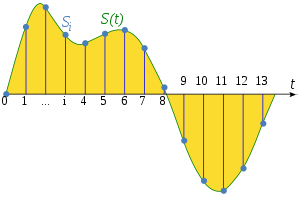

The sampling frequency or sampling rate, fs, is the average number of samples obtained in one second, thus fs = 1/T. Its units are samples per second or hertz e.g. 48 kHz is 48,000 samples per second. [source](https://en.wikipedia.org/wiki/Sampling_(signal_processing))

from the bottom code, we can understand that the sampling rate of the signal is 16000 hz. Let us resample it to 8000 hz since most of the speech related frequencies are present in 8000 hz.

In [ ]:


train_audio_path = '/content/drive/MyDrive/Colab Notebooks/data/train/audio'

all_wave = []
all_label = []
for label in tqdm(labels):
  # Here we ONLY select file that is in our labels(10 words) list,then check if inside is .wav or not
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')] 
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)



100%|██████████| 10/10 [55:46<00:00, 334.65s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/pickled_all_wave.pkl', 'wb') as fid:
     pickle.dump(all_wave, fid)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/pickled_all_label.pkl', 'wb') as fid:
     pickle.dump(all_label, fid)

In [13]:
# Read the data from the file
with open('/content/drive/MyDrive/Colab Notebooks/pickled_all_label.pkl', 'rb') as fid:
     all_label = pickle.load(fid)

In [6]:
# Read the data from the file
with open('/content/drive/MyDrive/Colab Notebooks/pickled_all_wave.pkl', 'rb') as fid:
     all_wave = pickle.load(fid)


here we convert the output labels to integer encoded and convert the integer encoded labels to a one-hot vector since it is a multi-target problem.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:

# For more information of LabelEncoder  https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
"""
LabelEncoder:
It can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.
>>>

>>> le = preprocessing.LabelEncoder()
>>> le.fit(["paris", "paris", "tokyo", "amsterdam"])
LabelEncoder()
>>> list(le.classes_)
['amsterdam', 'paris', 'tokyo']
>>> le.transform(["tokyo", "tokyo", "paris"])
array([2, 2, 1]...)
>>> list(le.inverse_transform([2, 2, 1]))
['tokyo', 'tokyo', 'paris']

"""

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

label_enconder = LabelEncoder()
y = label_enconder.fit_transform(all_label)
classes = list(label_enconder.classes_)
y = np_utils.to_categorical(y, num_classes=len(labels))



Using TensorFlow backend.
Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:
1D convolution layer (conv1d)

CONV1D Layer:
This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs.
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

-----------------
GRU Layer:
Based on available runtime hardware and constraints, this layer will choose different implementations (cuDNN-based or pure-TensorFlow) to maximize the performance. If a GPU is available and all the arguments to the layer meet the requirement of the CuDNN kernel (see below for details), the layer will use a fast cuDNN implementation.
https://keras.io/api/layers/recurrent_layers/gru/

----------------


In [17]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

**Split into train and validation set**

Next, we will train the model on 80% of the data and validate on the remaining 20%:




In [18]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)



#### Model Architecture


We used Conv1d and GRU layers to model the network that is used for speech recognition. Conv1d is a convolutional neural network which performs the convolution along only one dimension and GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU can also be considered as a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results.

In [11]:
from keras.layers import Bidirectional, BatchNormalization, CuDNNGRU, TimeDistributed
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(inputs)

#First Conv1D layer
x = Conv1D(8,13, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Second Conv1D layer
x = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Third Conv1D layer
x = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

x = Bidirectional(CuDNNGRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=False), merge_mode='sum')(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

#Flatten layer
# x = Flatten()(x)

#Dense Layer 1
x = Dense(256, activation='relu')(x)
outputs = Dense(len(labels), activation="softmax")(x)

model = Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 batch_normalization (BatchN  (None, 8000, 1)          4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424  

Define the loss function to be categorical cross-entropy since it is a multi-classification problem:


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('speech2text_model.hdf5', monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')



Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:


In [ ]:
hist = model.fit(
    x=x_train, 
    y=y_train,
    epochs=100, 
    callbacks=[early_stop], 
    batch_size=32, 
    validation_data=(x_valid,y_valid)
)

Epoch 1/100
168/168 [==============================] - 123s 510ms/step - loss: 2.2548 - accuracy: 0.1912 - val_loss: 2.2038 - val_accuracy: 0.1772
Epoch 2/100
168/168 [==============================] - 81s 481ms/step - loss: 1.6654 - accuracy: 0.3906 - val_loss: 2.2179 - val_accuracy: 0.2584
Epoch 3/100
168/168 [==============================] - 85s 504ms/step - loss: 1.2198 - accuracy: 0.5651 - val_loss: 1.2661 - val_accuracy: 0.5555
Epoch 4/100
168/168 [==============================] - 86s 511ms/step - loss: 0.9221 - accuracy: 0.6818 - val_loss: 1.0715 - val_accuracy: 0.6396
Epoch 5/100
168/168 [==============================] - 86s 513ms/step - loss: 0.7584 - accuracy: 0.7367 - val_loss: 0.8507 - val_accuracy: 0.7051
Epoch 6/100
168/168 [==============================] - 87s 519ms/step - loss: 0.6680 - accuracy: 0.7665 - val_loss: 0.8410 - val_accuracy: 0.7111
Epoch 7/100
168/168 [==============================] - 87s 519ms/step - loss: 0.5587 - accuracy: 0.8082 - val_loss: 0.5016 

Diagnostic plot:

we're going to lean on visualization again to understand the performance of the model over a period of time:


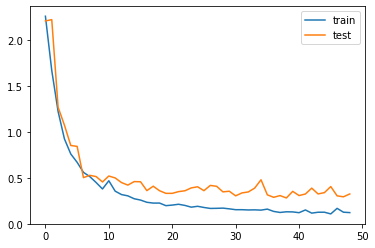

In [ ]:
from matplotlib import pyplot
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Save the best model


In [ ]:
model.save('speech2text_model.hdf5')

Here you can reload the model 

In [1]:
from tensorflow import keras
model = keras.models.load_model('/content/speech2text_model.hdf5')

Define the function that predicts text for the given audio:


In [24]:
def s2t_predict(audio, shape_num=8000):
    prob=model.predict(audio.reshape(1,shape_num,1))
    index=np.argmax(prob[0])
    return classes[index]




Prediction time! Make predictions on the validation data:


In [ ]:
import random
index=random.randint(0,len(x_valid)-1)
samples=x_valid[index].ravel()
print("Audio:",classes[np.argmax(y_valid[index])])
ipd.Audio(samples, rate=8000)



Audio: stop


### TEST Time:

In [19]:
model.evaluate(x = x_valid , y = y_valid , verbose= 1)

134/134 [==============================] - 33s 175ms/step - loss: 0.2855 - accuracy: 0.9247


[0.2854774594306946, 0.9247362017631531]

In [21]:
!sudo apt-get install libportaudio2
!pip install sounddevice

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (135 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 155222 files

In [ ]:
## This cell need to be run in local device to recored your own voice
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate, channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)


In [26]:
## USE from the list labels = ['left', 'go', 'yes', 'down', 'up', 'on', 'right', 'no', 'off', 'stop',]
#reading the voice commands
test, test_rate = librosa.load('download (1).wav', sr = 16000)
test_sample = librosa.resample(test, test_rate, 8000)
print(test_sample.shape)
ipd.Audio(test_sample,rate=8000)              



(8000,)


In [27]:
#converting voice commands to text
s2t_predict(test_sample)

'right'